In [199]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter


# hits_true = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_2sigma.h5","hits")

hits_true = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")
hits      = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF2_780594_24.h5", "hits")

display(hits)

,event_id,x,y,z,energy
0,2500000,-1454.381958,-1879.646973,1334.136597,0.000025
1,2500000,-1456.042847,-1895.306641,1338.477905,0.000100
2,2500000,-1460.264404,-1872.366577,1343.454712,0.000025
3,2500000,-1455.845459,-1895.423218,1346.833374,0.001275
4,2500000,-1460.868530,-1863.435059,1347.425171,0.000025
...,...,...,...,...,...
1433367,2500382,-1326.216553,882.556763,2720.339355,0.000025
1433368,2500382,-1328.215088,877.024475,2722.190918,0.000075
1433369,2500382,-1332.345825,883.020569,2724.646484,0.000075
1433370,2500382,-1322.920288,892.117676,2725.561768,0.000025


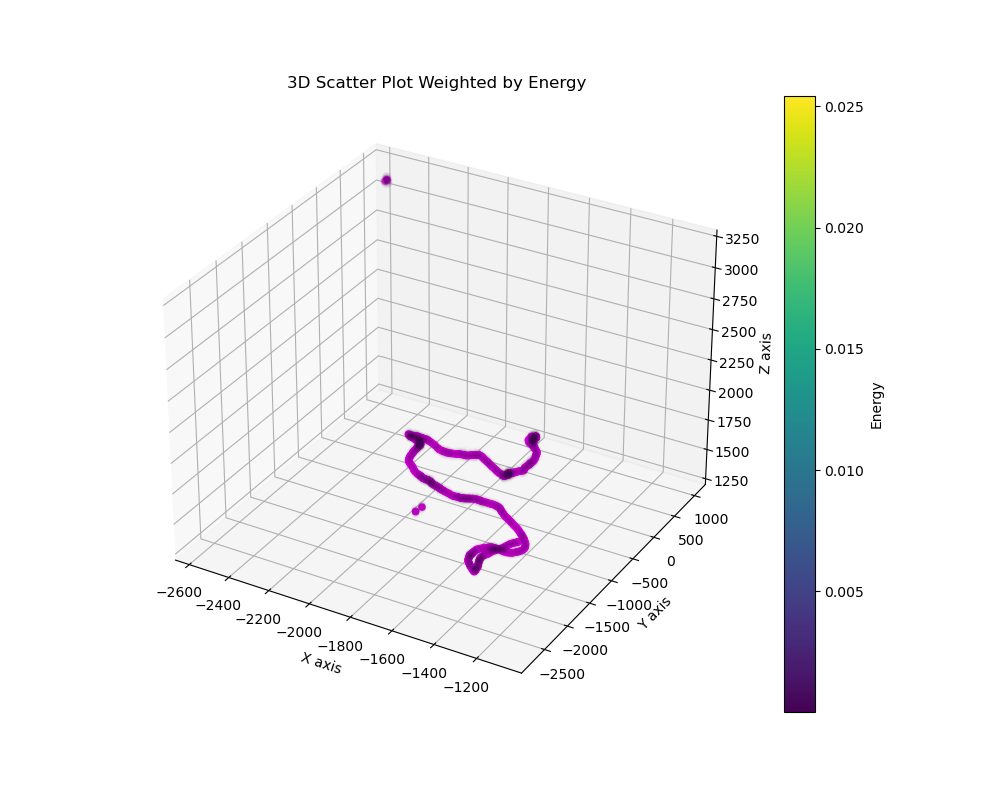

In [200]:
%matplotlib widget 

eid=2500000

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


cut_data = data[data.energy > 0.000]

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(cut_data.energy.min(), cut_data.energy.max())
colors = cmap(norm(cut_data.energy))


# Plot the scatter plot
scatter = ax.scatter(cut_data.x, cut_data.y, cut_data.z, c=colors, marker='o', alpha=0.01)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="magenta")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
cbar = plt.colorbar(mappable)
cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [201]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

display(data)
print(len(dist_matrix))

,event_id,x,y,z,energy
0,2500000,-2563.283936,976.639343,3134.813232,0.000125
1,2500000,-2562.692627,978.008240,3114.566162,0.000075
2,2500000,-2562.302002,977.626221,3124.896484,0.000200
3,2500000,-2562.294922,983.982544,3115.093750,0.000425
4,2500000,-2562.101807,990.520630,3126.202393,0.000050
...,...,...,...,...,...
3681,2500000,-1106.880493,-2184.252197,2603.753418,0.001075
3682,2500000,-1106.776245,-2192.500732,2604.408936,0.000300
3683,2500000,-1106.551758,-2192.417725,2594.038574,0.001225
3684,2500000,-1106.425659,-2177.215332,2576.122314,0.000025


3686


In [202]:

all_visited = []
radius  = 20


def GetMinima(index, all_visited):


    distances_from_index = dist_matrix[index] # distances for node to others
    sorted_indices = np.argsort(distances_from_index) # indexes sorted by smallest distance

    closest_nodes = sorted_indices[distances_from_index[sorted_indices] < radius]

    selected_rows = data.iloc[closest_nodes] # Df containing the nodes within distance

    # Compute the mean of x, y, and z columns
    mean_x = selected_rows['x'].median()
    mean_y = selected_rows['y'].median()
    mean_z = selected_rows['z'].median()
    mean_point = np.array([mean_x, mean_y, mean_z])

    all_visited = all_visited + list(closest_nodes)

    return mean_point




node_centers = []

for i in range(500):

    indexes = data.index.values

    indexes_set = set(indexes)
    all_visited_set = set(all_visited)

    # Convert arrays to sets and perform the difference
    filtered_indexes = list(indexes_set - all_visited_set)

    if not filtered_indexes:
        break

    # random_index = np.random.randint(0, len(data)) # pick a random index
    random_index = np.random.choice(filtered_indexes)
    median = GetMinima(random_index, all_visited)

    node_centers.append(median)

print(node_centers)

node_centers_df = pd.DataFrame(node_centers, columns=['x', 'y', 'z'])


[array([-1461.54199219, -1905.81384277,  1368.58691406]), array([-1227.11816406, -2398.05981445,  2437.27539062]), array([-1455.63415527, -1875.29748535,  1361.87719727]), array([-1127.54211426, -2154.28808594,  2665.87402344]), array([-1423.3302002 , -2430.75195312,  2191.81640625]), array([-1588.48510742, -2450.19775391,  2572.08642578]), array([-1220.87512207, -2387.24755859,  2442.92602539]), array([-1597.52563477, -2493.07226562,  2537.01708984]), array([-1556.52209473, -2584.74853516,  2554.75830078]), array([-1360.73022461, -2417.7421875 ,  2524.73071289]), array([-1194.82543945, -2228.85400391,  2416.42871094]), array([-1122.40515137, -2203.63720703,  2704.14697266]), array([-1304.5904541 , -2264.70458984,  2108.23095703]), array([-1163.14147949, -2206.27294922,  2427.3684082 ]), array([-1387.35595703, -2437.75537109,  2537.62866211]), array([-1467.78515625, -1914.54370117,  1396.63903809]), array([-1382.18994141, -2426.57128906,  2516.00830078]), array([-2554.54663086,   984.7

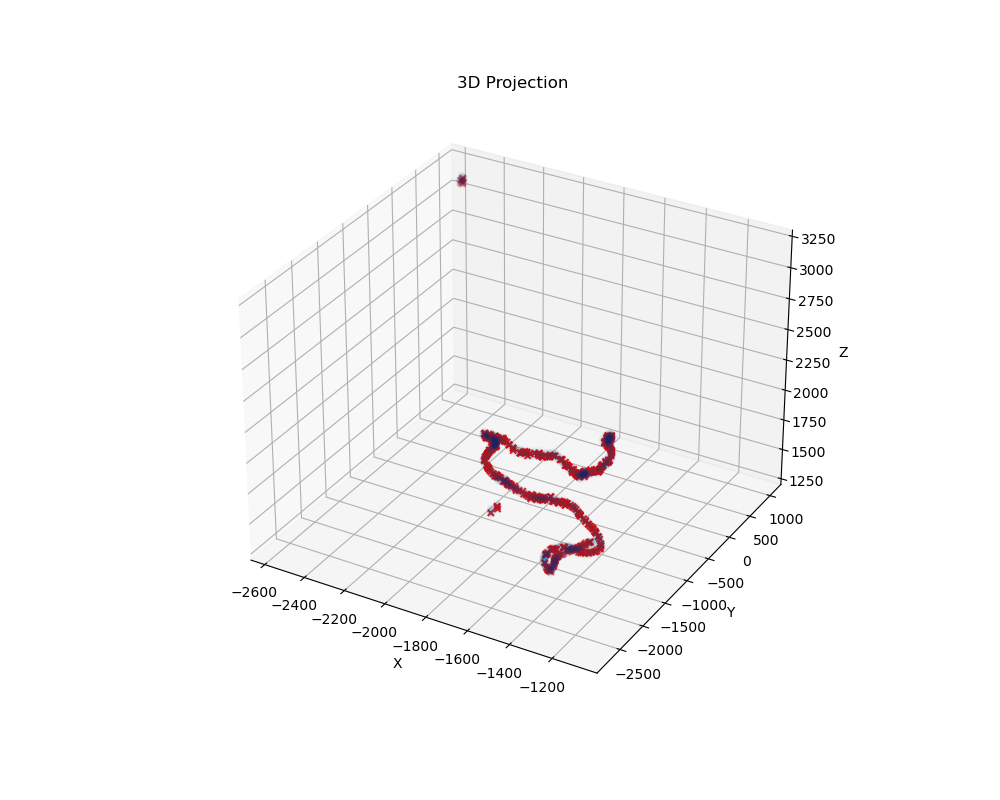

In [203]:


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')

ax.scatter(node_centers_df['x'], node_centers_df['y'], node_centers_df['z'], marker='x',c="r")



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()




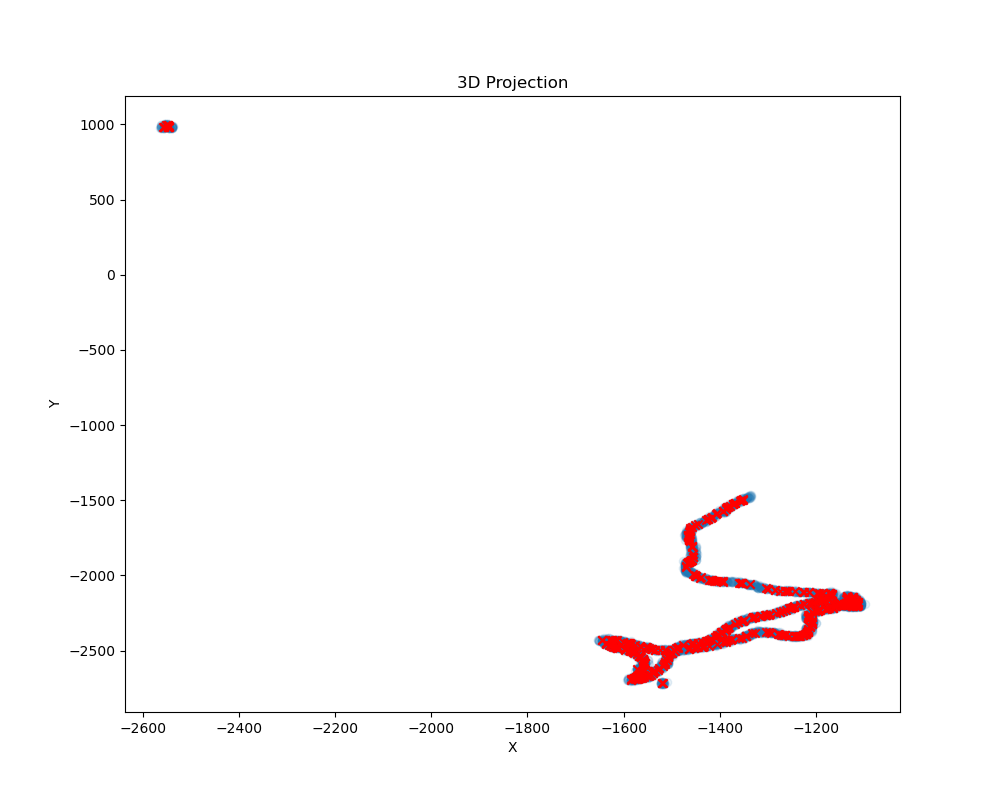

In [204]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o',alpha=0.1)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
plt.scatter(node_centers_df['x'], node_centers_df['y'], marker='x',c="r")

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()


In [235]:
# Create the bins ---- 
xmin=-3000
xmax=3000
xbw=25

ymin=-3000
ymax=3000
ybw=25

zmin=0
zmax=6000
zbw=25

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


databin = node_centers_df.copy()
databin["event_id"] = eid

 # Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)

#Loop over the rows in the dataframe and merge the energies. Also change the bin center to use the mean x,y,z position
x_mean_arr = []
y_mean_arr = []
z_mean_arr = []
energy_mean_arr = []
x_mean_arr_temp = np.array([])
y_mean_arr_temp = np.array([])
z_mean_arr_temp = np.array([])
summed_energy = 0
event_id = 0

counter = 0

# test_df = test_df.reset_index()
databin = databin.sort_values(by=['x_smear', 'y_smear', 'z_smear'])
databin["energy"] = 1


for index, row in databin.iterrows():

    # First row
    if (counter == 0):
        temp_x = row["x_smear"]
        temp_y = row["y_smear"]
        temp_z = row["z_smear"]
        summed_energy +=row["energy"]
        event_id = row["event_id"]
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        counter+=1
        continue

    # Final row
    if index == databin.index[-1]:
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]

        if (summed_energy != 0): 
            x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
            y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
            z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
            energy_mean_arr.append(summed_energy)


    # Same bin
    if (row["x_smear"] == temp_x and row["y_smear"] == temp_y and row["z_smear"] == temp_z):
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]

    # Aggregate and store for next 
    else:
        if (summed_energy != 0): 
            x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
            y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
            z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
            energy_mean_arr.append(summed_energy)
        
        temp_x = row["x_smear"]
        temp_y = row["y_smear"]
        temp_z = row["z_smear"]
        summed_energy = 0
        x_mean_arr_temp = np.array([])
        y_mean_arr_temp = np.array([])
        z_mean_arr_temp = np.array([])
        
        
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]
        

    counter+=1

events = np.ones_like(energy_mean_arr)*event_id

# Make the dataframe again
databin = pd.DataFrame({  "event_id" : events, "x" : x_mean_arr,  "y" : y_mean_arr,  "z" : z_mean_arr,  "energy" : energy_mean_arr  }) 

display(databin)

,event_id,x,y,z,energy
0,2500000.0,-2556.207031,981.760376,3115.609985,2.0
1,2500000.0,-2553.374512,988.909058,3125.278320,2.0
2,2500000.0,-2546.147339,983.632935,3110.002014,4.0
3,2500000.0,-2546.775574,989.600433,3142.410461,4.0
4,2500000.0,-1628.116394,-2466.884399,2546.323853,2.0
...,...,...,...,...,...
214,2500000.0,-1122.303516,-2181.990479,2634.312598,5.0
215,2500000.0,-1118.897298,-2190.821289,2714.717367,3.0
216,2500000.0,-1121.513550,-2156.110962,2686.118774,2.0
217,2500000.0,-1117.099609,-2165.809570,2715.140625,1.0


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_56645/3669572966.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 8))


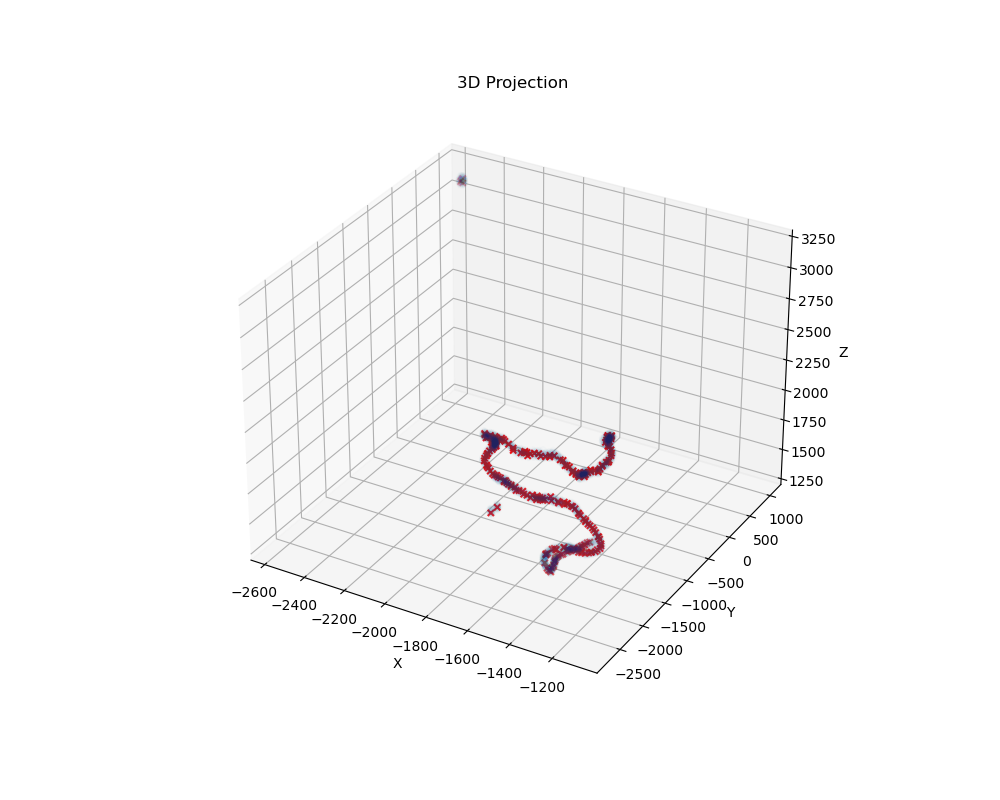

In [236]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')

ax.scatter(databin['x'], databin['y'], databin['z'], marker='x',c="r")




ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

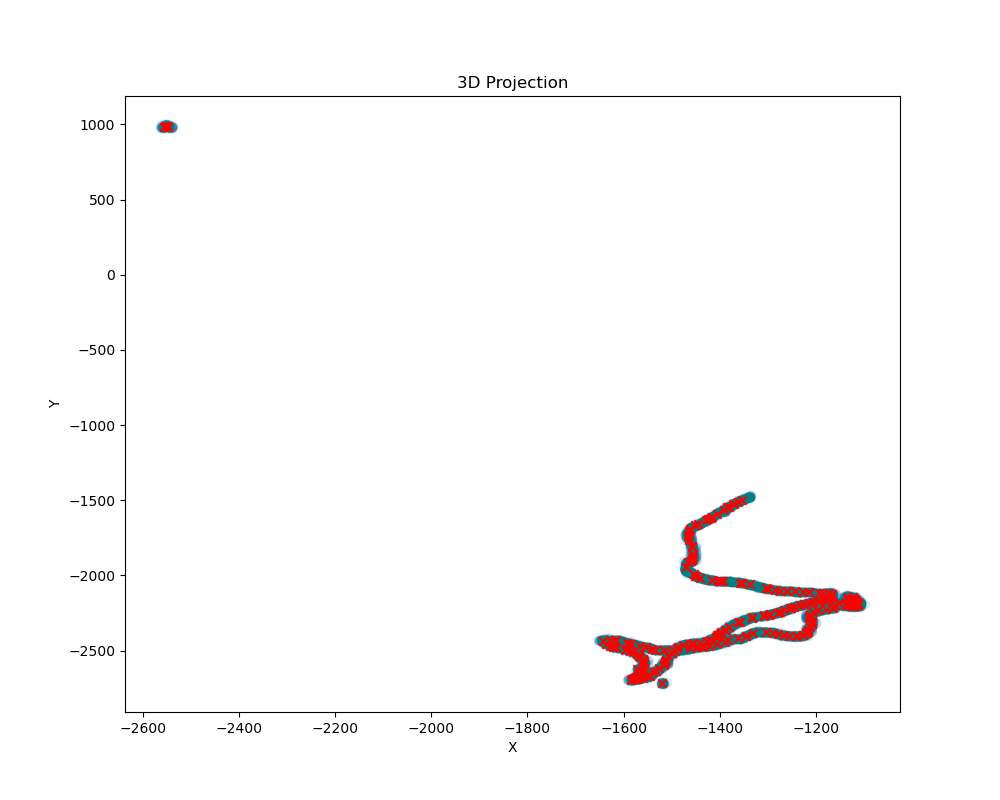

In [243]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o',alpha=0.1)
plt.scatter(data_true['x'], data_true['y'], marker='o',color="Teal")
plt.scatter(databin['x'], databin['y'], marker='x',c="r")

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()